## Setup



In [ ]:
try:
  import colab
  !pip install --upgrade pip gwpy &> /dev/null
except:
  pass

! pip install tfx gwpy &> /dev/null

In [ ]:

import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()
import shutil

from skimage import io
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os, glob
from glob import glob
import pickle
from sys import getsizeof

import datetime,time

import collections, random, re
from collections import Counter
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

import tfx
from typing import Dict, List, Text
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import ImportExampleGen
from tfx.components import CsvExampleGen
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input
from tfx.proto import evaluator_pb2
from tfx.proto import example_gen_pb2
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.components import ModelValidator

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('TFMA version: {}'.format(tfma.VERSION_STRING))

from google.colab import drive
drive.mount('/content/gdrive')


The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
TensorFlow version: 2.4.1
TFX version: 0.29.0
TFMA version: 0.29.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Cleanup 
!rm -rf /content/tf*
!rm -rf data.*
!sudo rm -r /content/tfx/data

rm: cannot remove '/content/tfx/data': No such file or directory


In [ ]:
# Create tfx folders
! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/serving_model
! mkdir /content/tfx/imgtfrecord

In [ ]:
# Resize image utility
def resize():
  src_root = '/content/gdrive/MyDrive/SEM2/258DL/258 Project/data/'
  image_dir = os.path.join(src_root, 'Flickr8k_Dataset')
  image_dir_resized = os.path.join(src_root, 'resized/')

  maxsize = (224,224)
  for input_img_path in pathlib.Path(image_dir).iterdir():
      output_img_path = image_dir_resized
      with Image.open(input_img_path) as im:
          im.thumbnail(maxsize)
          fname = im.filename.split("/")[len(im.filename.split("/"))-1]
          im.save(output_img_path+fname, "jpeg", dpi=(300,300))

## Set up pipeline paths

In [ ]:
src_root = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr'
#shutil.copytree(src_root, _data_root)

image_dir = os.path.join(src_root, 'Flickr8k_Dataset')
caption_dir = os.path.join(src_root,'Flickr8k_text')


# Alternate
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH_FLICKR = KaggleDatasets().get_gcs_path('flickr8k-sau')

In [ ]:
## Define all constants 
_pipeline_name = 'iassist'
_tfx_root = os.path.join(os.getcwd(), 'tfx');        
_data_root = os.path.join(_tfx_root, 'data'); #
_pipeline_root = os.path.join(_tfx_root, 'pipelines');    
_metadata_db_root = os.path.join(_tfx_root, 'metadata.db');   
_log_root = os.path.join(_tfx_root, 'logs');
_model_root = os.path.join(_tfx_root, 'model');
_serving_model_dir = os.path.join(_tfx_root, 'serving_model')

_caption_path = os.path.join(_data_root, 'captions.txt')#
_img_tf_record_path = os.path.join(_tfx_root, 'imgtfrecord')


_caption_transform_file = os.path.join(_tfx_root, 'caption_transform.py')
_img_transform_file = os.path.join(_tfx_root, 'img_transform.py')

In [ ]:
# Working on a small dataset as colab was crashing processing whole set
# another option is to use the above resize utility and use only small sized images

image_dir = os.path.join(src_root, 'sample') # CHANGE to Flickr8k_Dataset
caption_dir = os.path.join(src_root,'Flickr8k_text/cleaned')
caption_file = caption_dir+ "/cleaned_captions.csv"


## Check if data is loaded right

In [ ]:
captions_df = pd.read_csv(caption_file)
print(captions_df.shape)
captions_df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
image_dataset = glob(os.path.join(image_dir, '*.jpg'))
len(image_dataset)

50

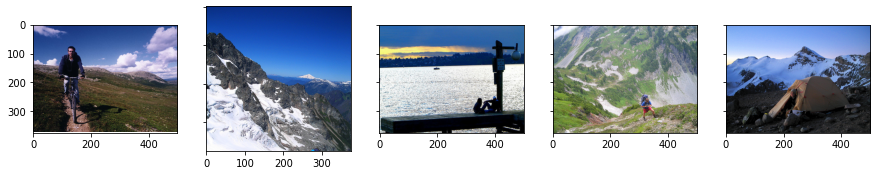

In [ ]:
def plot_image(images):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
   
    for ax,image in zip(axes, images):
        ax.imshow(io.imread(image))
        
plot_image(image_dataset[:5])

## Convert images to TFRecord

In [ ]:
tfrecords_filename = _img_tf_record_path + "/tf_record.record"

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() 
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def read_image_as_byte_string(path):
  image_string = open(str(path), 'rb').read()
  return image_string

def image_example(record_path, data_dir):
  image_string = read_image_as_byte_string(record_path)
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'image/height': _int64_feature(image_shape[0]),
      'image/width': _int64_feature(image_shape[1]),
      'image/depth': _int64_feature(image_shape[2]),
      'image/raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

with tf.io.TFRecordWriter(tfrecords_filename) as writer:
  for path in pathlib.Path(image_dir).iterdir():
    example = image_example(path, _data_root)
    writer.write(example.SerializeToString())


## **Create the InteractiveContext**


In [ ]:
context = InteractiveContext(pipeline_root=_tfx_root)

## ExampleGen for captions

In [ ]:
example_gen_caption = CsvExampleGen(input_base=caption_dir)
context.run(example_gen_caption)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 2
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 2
        type_id: 5
        uri: "/content/tfx/CsvExampleGen/examples/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:3319294,xor_checksum:1609685758,sum_checksum:1609685758"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [ ]:
artifact_caption = example_gen_caption.outputs['examples'].get()[0]
print(artifact_caption.split_names, artifact_caption.uri)

["train", "eval"] /content/tfx/CsvExampleGen/examples/2


## ExampleGen for Images

In [ ]:
output_config = example_gen_pb2.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 example_gen_pb2.SplitConfig.Split(name='train',
                                                   hash_buckets=8),
                 example_gen_pb2.SplitConfig.Split(name='eval',
                                                   hash_buckets=2)
             ]))
example_gen_img = ImportExampleGen(input_base=_img_tf_record_path, output_config=output_config)
context.run(example_gen_img)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/content/tfx/ImportExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:5386359,xor_checksum:1618677131,sum_checksum:1618677131"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

## StatisticsGen for captions

In [ ]:
statistics_gen_caption = StatisticsGen(examples=example_gen_caption.outputs['examples'])
context.run(statistics_gen_caption)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 5
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 3
        type_id: 8
        uri: "/content/tfx/StatisticsGen/statistics/3"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        create_time_since_epoch: 1618678182667
        last_update_time_since_epoch: 1618678188289
        , artifact_type: id: 8
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [ ]:
context.show(statistics_gen_caption.outputs['statistics'])

In [ ]:
artifact_img = example_gen_img.outputs['examples'].get()[0]
print(artifact_img.split_names, artifact_img.uri)

["train", "eval"] /content/tfx/ImportExampleGen/examples/1


## StatisticsGen for images

In [ ]:
statistics_gen_img = StatisticsGen(examples=example_gen_img.outputs['examples'])
context.run(statistics_gen_img)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 6
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 4
        type_id: 8
        uri: "/content/tfx/StatisticsGen/statistics/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        create_time_since_epoch: 1618678281810
        last_update_time_since_epoch: 1618678284540
        , artifact_type: id: 8
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [ ]:
context.show(statistics_gen_img.outputs['statistics'])

## Schemagen for captions

In [ ]:
schema_gen_caption = SchemaGen(
    statistics=statistics_gen_caption.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen_caption)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 7
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 5
        type_id: 10
        uri: "/content/tfx/SchemaGen/schema/7"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 10
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

## Schemagen for images

In [ ]:
schema_gen_img = SchemaGen(
    statistics=statistics_gen_img.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen_img)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 8
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 6
        type_id: 10
        uri: "/content/tfx/SchemaGen/schema/8"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 10
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

## ExampleValidator for captions

In [ ]:
example_validator_caption = ExampleValidator(
    statistics=statistics_gen_caption.outputs['statistics'],
    schema=schema_gen_caption.outputs['schema'])
context.run(example_validator_caption)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 10
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 7
        type_id: 12
        uri: "/content/tfx/ExampleValidator/anomalies/9"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        create_time_since_epoch: 1618680807479
        last_update_time_since_epoch: 1618680807512
        , artifact_type: id: 12
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

## ExampleValidator for images

In [ ]:
example_validator_img = ExampleValidator(
    statistics=statistics_gen_img.outputs['statistics'],
    schema=schema_gen_img.outputs['schema'])
context.run(example_validator_img)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 11
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 8
        type_id: 12
        uri: "/content/tfx/ExampleValidator/anomalies/11"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 12
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

## Transform for caption

In [ ]:
transform_caption = Transform(
    examples=example_gen_caption.outputs['examples'],
    schema=schema_gen_caption.outputs['schema'],
    module_file=_caption_transform_file)

context.run(transform_caption)

## Transform for images

In [ ]:
transform_img = Transform(
    examples=example_gen_img.outputs['examples'],
    schema=schema_gen_img.outputs['schema'],
    module_file=_img_transform_file)

context.run(transform_img)

## Trainer

In [ ]:
trainer = Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      schema=schema_gen.outputs['schema'],
      transform_graph=transform.outputs['transform_graph'],
      train_args=trainer_pb2.TrainArgs(num_steps=1000),
      eval_args=trainer_pb2.EvalArgs(num_steps=500))

context.run(trainer)


## Model artifacts

In [ ]:
model_artifact_dir = trainer.outputs['model'].get()[0].uri
pp.pprint(os.listdir(model_artifact_dir))
model_dir = os.path.join(model_artifact_dir, 'serving_model_dir')
pp.pprint(os.listdir(model_dir))


In [ ]:
log_dir = os.path.join(model_artifact_dir, 'logs')

%load_ext tensorboard
%tensorboard --logdir {log_dir}